In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
ticker = "SPY"

r = pd.read_csv("../data/interim/log_returns.csv", index_col=0, parse_dates=True)

r.head()

/tmp/ipykernel_1975/3126732154.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  r = pd.read_csv("../data/interim/log_returns.csv", index_col=0, parse_dates=True)


,log_return
1,-0.000164
2,-0.002902
3,0.006123
4,0.000218
5,0.000654


In [3]:
r.shape

(3042, 1)

# Backtesting Settings

In [4]:
window = 1000
alpha = 0.99

# Define VaR Functions

### Normal VaR

In [5]:
def normal_var(data, alpha):
    mu = data.mean()
    sigma = data.std()
    return stats.norm.ppf(1 - alpha, mu, sigma)

### Student-t VaR

In [6]:
def t_var(data, alpha):
    nu, mu, sigma = stats.t.fit(data)
    return stats.t.ppf(1 - alpha, nu, mu, sigma)

### Skew VaR

In [7]:
def skew_var(data, alpha):
    a, mu, sigma = stats.skewnorm.fit(data)
    return stats.skewnorm.ppf(1 - alpha, a, mu, sigma)

# Rolling VaR Forecast

In [8]:
var_normal = []
var_t = []
var_skew = []
actual_returns = []

for i in range(window, len(r)):
    sample = r.iloc[i-window:i]

    var_normal.append(normal_var(sample, alpha))
    var_t.append(t_var(sample, alpha))
    var_skew.append(skew_var(sample, alpha))
    actual_returns.append(r.iloc[i])

var_normal = np.array(var_normal)
var_t = np.array(var_t)
var_skew = np.array(var_skew)
actual_returns = np.array(actual_returns)

In [16]:
var_normal = np.array(var_normal).flatten()
var_t = np.array(var_t).flatten()
var_skew = np.array(var_skew).flatten()
actual_returns = np.array(actual_returns).flatten()

In [24]:
var_table = pd.DataFrame({
    "Date": r.index[window:],
    "Actual Return": actual_returns,
    "VaR Normal": var_normal,
    "VaR t-Distribution": var_t,
    "VaR Skewed Normal": var_skew
}) 
var_table.head()

,Date,Actual Return,VaR Normal,VaR t-Distribution,VaR Skewed Normal
0,1001,0.002057,-0.017250,-0.022311,-0.018471
1,1002,-0.000261,-0.017248,-0.022303,-0.018470
2,1003,-0.001197,-0.017244,-0.022324,-0.018468
3,1004,0.000486,-0.017247,-0.022373,-0.018465
4,1005,0.002055,-0.017247,-0.022374,-0.018465


In [25]:
var_table.to_csv("../results/tables/var_backtesting.csv", index=False)

In [17]:
var_normal

array([-0.01725027, -0.01724838, -0.01724408, ..., -0.02561361,
       -0.02562345, -0.02564762], shape=(2042,))

# Count Breaches

In [9]:
breach_normal = actual_returns < var_normal
breach_t = actual_returns < var_t
breach_skew = actual_returns < var_skew

print("Expected breach rate:", 1 - alpha)
print("Normal breach rate:", breach_normal.mean())
print("Student-t breach rate:", breach_t.mean())
print("Skew breach rate:", breach_skew.mean())

Expected breach rate: 0.010000000000000009
Normal breach rate: 0.02693437806072478
Student-t breach rate: 0.015300626126562559
Skew breach rate: 0.02335455915490661


In [18]:
breach_normal = actual_returns.flatten() < var_normal
breach_t = actual_returns.flatten() < var_t
breach_skew = actual_returns.flatten() < var_skew

print("Expected breach rate:", 1 - alpha)
print("Normal breach rate:", breach_normal.mean())
print("Student-t breach rate:", breach_t.mean())
print("Skew breach rate:", breach_skew.mean())

Expected breach rate: 0.010000000000000009
Normal breach rate: 0.02693437806072478
Student-t breach rate: 0.015670910871694418
Skew breach rate: 0.023506366307541625


# Kupiec Proportion Test

### Kupiec Function

In [19]:
def kupiec_test(breaches, alpha):
    T = len(breaches)
    x = breaches.sum()
    p = 1 - alpha
    phat = x / T

    LR = -2 * (
        (T - x) * np.log((1 - p) / (1 - phat)) +
        x * np.log(p / phat)
    )

    p_value = 1 - stats.chi2.cdf(LR, df=1)

    return x, phat, LR, p_value

In [20]:
models = {
    "Normal": breach_normal,
    "Student-t": breach_t,
    "Skew-Normal": breach_skew
}

results = []

for name, breaches in models.items():
    x, phat, LR, pval = kupiec_test(breaches, alpha)
    results.append([name, x, phat, LR, pval])

kupiec_results = pd.DataFrame(
    results,
    columns=["Model", "Breaches", "Observed Rate", "LR Statistic", "p-value"]
)

kupiec_results

,Model,Breaches,Observed Rate,LR Statistic,p-value
0,Normal,55,0.026934,40.424929,2.043175e-10
1,Student-t,32,0.015671,5.656609,1.738971e-02
2,Skew-Normal,48,0.023506,27.267866,1.771308e-07


In [22]:
kupiec_results.to_csv("../results/tables/kupiec_results.csv", index=False)

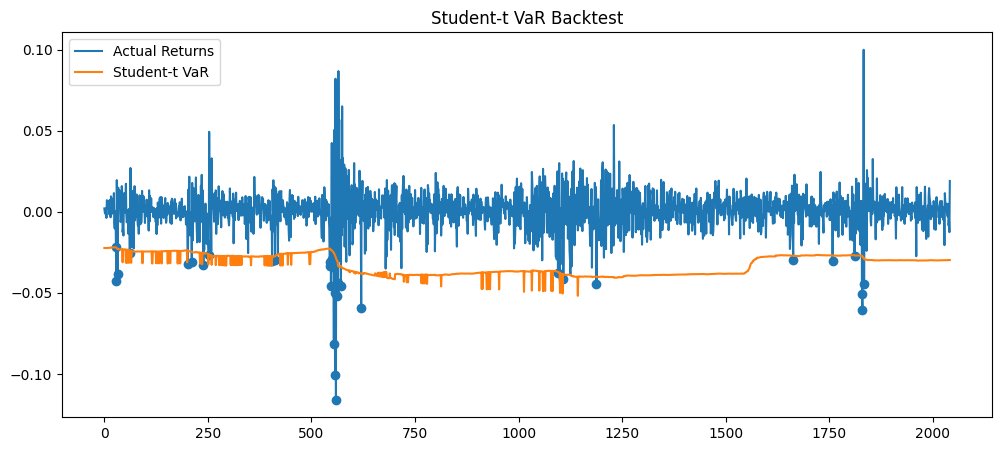

In [21]:
plt.figure(figsize=(12,5))
plt.plot(actual_returns, label="Actual Returns")
plt.plot(var_t, label="Student-t VaR")
plt.scatter(
    np.where(breach_t),
    actual_returns[breach_t],
    marker='o'
)
plt.title("Student-t VaR Backtest")
plt.legend()
plt.show()